In [20]:
# Links and codes
# http://blog.kaggle.com/2017/12/22/carvana-image-masking-first-place-interview/
# 1st place solution
# https://github.com/asanakoy/kaggle_carvana_segmentation

# 2018 nuclei data science bowl
# https://www.kaggle.com/c/data-science-bowl-2018/data
# winners:https://datasciencebowl.com/2018winners/

# Mask rcnn by 3rd place winner: https://github.com/Gelu74/DSB_2018
# Lots others: https://github.com/Gelu74/DSB_2018/blob/master/README.md

# deeplab v3
# https://github.com/sthalles/deeplab_v3
# https://github.com/bonlime/keras-deeplab-v3-plus
# https://github.com/handong1587/handong1587.github.io/blob/master/_posts/deep_learning/2015-10-09-segmentation.md

# topcoders, 1st place solution
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/54741
# Torch solution: https://github.com/neptune-ml/open-solution-data-science-bowl-2018

# 5th place keras solution (mask rcnn)
# https://github.com/mirzaevinom/data_science_bowl_2018/blob/master/codes/model.py

# http://blog.kaggle.com/2017/06/29/2017-data-science-bowl-predicting-lung-cancer-2nd-place-solution-write-up-daniel-hammack-and-julian-de-wit/

# Cardiac MRI segmentation
# Use the different models and see
# https://github.com/chuckyee/cardiac-segmentation/tree/master/rvseg/models

# 2017 national data science bowl
# https://www.kaggle.com/c/data-science-bowl-2017#description
# 2nd place solution for the 2017 national datascience bowl
# http://juliandewit.github.io/kaggle-ndsb2017/
# Top 2017 algo
# https://datasciencebowl.com/2017algorithms/

# Read lung segmentation blog
# http://blog.kaggle.com/2017/05/16/data-science-bowl-2017-predicting-lung-cancer-solution-write-up-team-deep-breath/

# Changelog
- ideas: 
   a) I can check the images for which the result is bad. 
   b) Do template matching. I can extract the boundary of salt-sediment using the mask image and find those on the test image and see how it performs. 
   c) Pretrained model + freezing + decoding part
   d) Feature extraction techniques
   e) Image similarity deep ranking
   
- I have run the resnet but the model output is giving 2 channel image. And the model somehow predicts the images the same way.
- Mainly looking at whether data augmentation affects accuracy
       - Elastic transform, rotation, Gaussian Noise, poisson downsampling

- Added data augmentation methods 
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)

# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [21]:
import numpy as np
import pandas as pd
import cv2 as cv

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [22]:
from IPython import get_ipython

ip = get_ipython()

if ip == None:
    print('Python Script from notebook is running.')
    plt.switch_backend('agg')
else:
    print('Notebook is running.')

Notebook is running.


# Params and helpers

In [23]:
img_size_ori = 101
img_size_target = 128
img_chan = 1

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target)) #, mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori)) #, mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [24]:
dataset_path = "" #"tgs-salt-identification-challenge/"
train_df = pd.read_csv("../input/"+ dataset_path + "train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/" + dataset_path + "depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [394]:
train_df["images"] = [np.array(load_img("../input/" + dataset_path + "train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

In [395]:
train_df["masks"] = [np.array(load_img("../input/" + dataset_path + "train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [396]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [397]:
def cov_to_class(val):    
    for i in range(0, 21):
        if val * 20 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [35]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,11
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,20
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,3
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


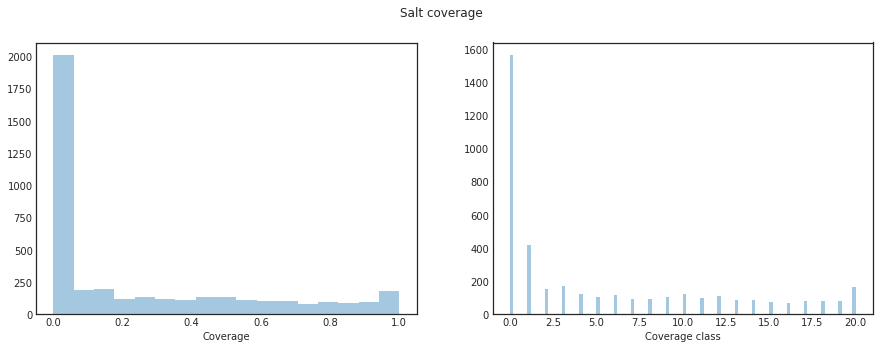

In [261]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=100, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/salt_coverage.svg','wb'), dpi=150)

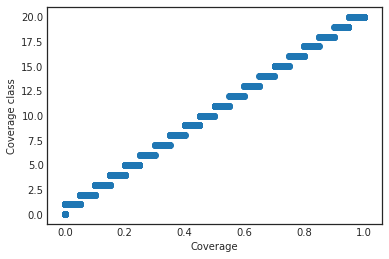

In [260]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/scatter_plot_coverage.svg', 'wb'), dpi=150)

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

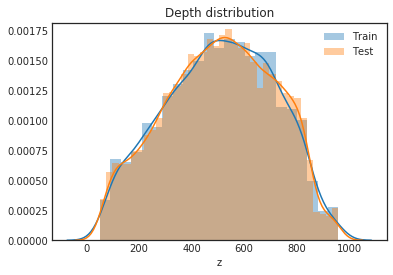

In [38]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/depth_distribution.svg', 'wb'), dpi=150)

# Show some example images

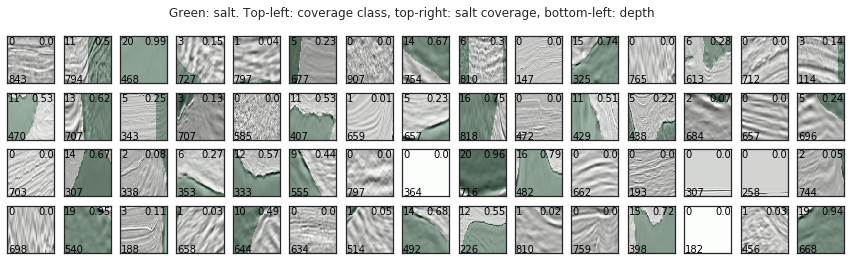

In [39]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/salt_coverage.svg', 'wb'), dpi=150)

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [40]:
# import copy
# train_df_orig = copy.deepcopy(train_df)

# # salt train_df
# train_df = train_df_salt = train_df[train_df.coverage == 0]

# # nosalt train_df
# train_df_nosalt = train_df[train_df.coverage != 0]


In [41]:
print(train_df_orig.describe())
print(train_df.describe())

NameError: name 'train_df_orig' is not defined

In [398]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.25, stratify=train_df.coverage_class, random_state=1337)

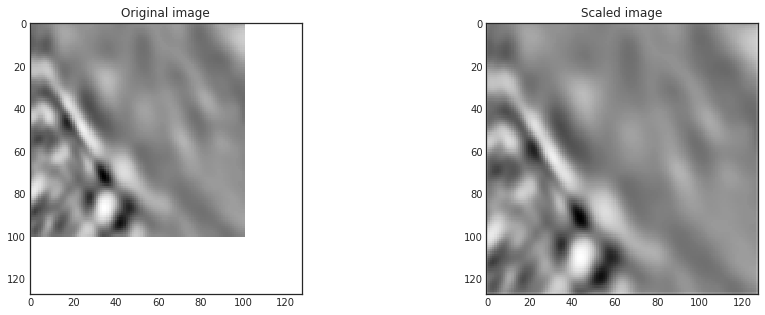

In [43]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/scaled_original.svg', 'wb'), dpi=150)

# Build model

In [44]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [45]:
model = Model(input_layer, output_layer)

In [46]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

# Data augmentation

In [48]:
from itertools import product, chain
import imgaug as ia
from imgaug import augmenters as iaa

In [49]:
def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img


def relabel_random_colors(img, max_colours=1000):
    keys = list(range(1, max_colours, 1))
    np.random.shuffle(keys)
    values = list(range(1, max_colours, 1))
    np.random.shuffle(values)
    funky_dict = {k: v for k, v in zip(keys, values)}
    funky_dict[0] = 0

    h, w = img.shape

    for i, j in product(range(h), range(w)):
        img[i, j] = funky_dict[img[i, j]]
    return img

def get_crop_pad_sequence(vertical, horizontal):
    top = int(vertical / 2)
    bottom = vertical - top
    right = int(horizontal / 2)
    left = horizontal - right
    return (top, right, bottom, left)

In [50]:
def _perspective_transform_augment_images(self, images, random_state, parents, hooks):
    result = images
    if not self.keep_size:
        result = list(result)

    matrices, max_heights, max_widths = self._create_matrices(
        [image.shape for image in images],
        random_state
    )

    for i, (M, max_height, max_width) in enumerate(zip(matrices, max_heights, max_widths)):
        warped = cv.warpPerspective(images[i], M, (max_width, max_height))
        if warped.ndim == 2 and images[i].ndim == 3:
            warped = np.expand_dims(warped, 2)
        if self.keep_size:
            h, w = images[i].shape[0:2]
            warped = ia.imresize_single_image(warped, (h, w))

        result[i] = warped

    return result


iaa.PerspectiveTransform._augment_images = _perspective_transform_augment_images
affine_seq = iaa.Sequential([
    # General
    iaa.SomeOf((1, 2),
               [iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
                iaa.Affine(rotate=(0, 360),
                           translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, mode='symmetric'),
                iaa.CropAndPad(percent=(-0.25, 0.25), pad_mode='symmetric')
                ]),
    # Deformations
    iaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.02, 0.04))),
    iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.10))),
], random_order=True)

def crop_seq(crop_size):
    seq = iaa.Sequential([affine_seq,
                          RandomCropFixedSize(px=crop_size)], random_order=False)
    return seq

class PadFixed(iaa.Augmenter):
    PAD_FUNCTION = {'reflect': cv.BORDER_REFLECT_101,
                    'replicate': cv.BORDER_REPLICATE,
                    }

    def __init__(self, pad=None, pad_method=None, name=None, deterministic=False, random_state=None):
        super().__init__(name, deterministic, random_state)
        self.pad = pad
        self.pad_method = pad_method

    def _augment_images(self, images, random_state, parents, hooks):
        result = []
        for i, image in enumerate(images):
            image_pad = self._pad(image)
            result.append(image_pad)
        return result

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        result = []
        return result

    def _pad(self, img):
        img_ = img.copy()

        if self._is_expanded_grey_format(img):
            img_ = np.squeeze(img_, axis=-1)

        h_pad, w_pad = self.pad
        img_ = cv.copyMakeBorder(img_.copy(), h_pad, h_pad, w_pad, w_pad, PadFixed.PAD_FUNCTION[self.pad_method])

        if self._is_expanded_grey_format(img):
            img_ = np.expand_dims(img_, axis=-1)

        return img_

    def get_parameters(self):
        return []

    def _is_expanded_grey_format(self, img):
        if len(img.shape) == 3 and img.shape[2] == 1:
            return True
        else:
            return False
class RandomCropFixedSize(iaa.Augmenter):
    def __init__(self, px=None, name=None, deterministic=False, random_state=None):
        super(RandomCropFixedSize, self).__init__(name=name, deterministic=deterministic, random_state=random_state)
        self.px = px
        if isinstance(self.px, tuple):
            self.px_h, self.px_w = self.px
        elif isinstance(self.px, int):
            self.px_h = self.px
            self.px_w = self.px
        else:
            raise NotImplementedError

    def _augment_images(self, images, random_state, parents, hooks):

        result = []
        seeds = random_state.randint(0, 10 ** 6, (len(images),))
        for i, image in enumerate(images):
            seed = seeds[i]
            image_cr = self._random_crop(seed, image)
            result.append(image_cr)
        return result

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        result = []
        return result

    def _random_crop(self, seed, image):
        height, width = image.shape[:2]

        np.random.seed(seed)
        if height > self.px_h:
            crop_top = np.random.randint(height - self.px_h)
        elif height == self.px_h:
            crop_top = 0
        else:
            raise ValueError("To big crop height")
        crop_bottom = crop_top + self.px_h

        np.random.seed(seed + 1)
        if width > self.px_w:
            crop_left = np.random.randint(width - self.px_w)
        elif width == self.px_w:
            crop_left = 0
        else:
            raise ValueError("To big crop width")
        crop_right = crop_left + self.px_w

        if len(image.shape) == 2:
            image_cropped = image[crop_top:crop_bottom, crop_left:crop_right]
        else:
            image_cropped = image[crop_top:crop_bottom, crop_left:crop_right, :]
        return image_cropped

    def get_parameters(self):
        return []


class InferencePad(iaa.Augmenter):
    def __init__(self, divisor=2, pad_mode='symmetric', name=None, deterministic=False, random_state=None):
        super(InferencePad, self).__init__(name=name, deterministic=deterministic, random_state=random_state)
        self.divisor = divisor
        self.pad_mode = pad_mode

    def _augment_keypoints(self, keypoints_on_images, random_state, parents, hooks):
        return keypoints_on_images

    def _augment_images(self, images, random_state, parents, hooks):

        result = []
        for i, image in enumerate(images):
            image_padded = self._pad_image(image)
            result.append(image_padded)
        return result

    def _pad_image(self, image):
        height = image.shape[0]
        width = image.shape[1]

        pad_sequence = self._get_pad_sequence(height, width)
        augmenter = iaa.Pad(px=pad_sequence, keep_size=False, pad_mode=self.pad_mode)
        return augmenter.augment_image(image)

    def _get_pad_sequence(self, height, width):
        pad_vertical = self._get_pad(height)
        pad_horizontal = self._get_pad(width)
        return get_crop_pad_sequence(pad_vertical, pad_horizontal)

    def _get_pad(self, dim):
        if dim % self.divisor == 0:
            return 0
        else:
            return self.divisor - dim % self.divisor

    def get_parameters(self):
        return [self.divisor, self.pad_mode]
    
def crop_seq(crop_size):
    seq = iaa.Sequential([affine_seq,
                          RandomCropFixedSize(px=crop_size)], random_order=False)
    return seq


def padding_seq(pad_size, pad_method):
    seq = iaa.Sequential([PadFixed(pad=pad_size, pad_method=pad_method),
                          ]).to_deterministic()
    return seq


def pad_to_fit_net(divisor, pad_mode, rest_of_augs=iaa.Noop()):
    return iaa.Sequential(InferencePad(divisor, pad_mode), rest_of_augs)


In [51]:
# Link: https://gist.github.com/oeway/2e3b989e0343f0884388ed7ed82eb3b0

import numpy as np
import scipy
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import collections
from PIL import Image
import numbers

def center_crop(x, center_crop_size):
    assert x.ndim == 2
    centerw, centerh = x.shape[0] // 2, x.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    return x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh]


def to_tensor(x):
    import torch
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x).float()


def random_num_generator(config, random_state=np.random):
    if config[0] == 'uniform':
        ret = random_state.uniform(config[1], config[2], 1)[0]
    elif config[0] == 'lognormal':
        ret = random_state.lognormal(config[1], config[2], 1)[0]
    else:
        print(config)
        raise Exception('unsupported format')
    return ret


def poisson_downsampling(image, peak, random_state=np.random):
    if not isinstance(image, np.ndarray):
        imgArr = np.array(image, dtype='float32')
    else:
        imgArr = image.astype('float32')
    Q = imgArr.max(axis=(0)) / peak
    if Q[0] == 0:
        return imgArr
    ima_lambda = imgArr / Q
    noisy_img = random_state.poisson(lam=ima_lambda)
    return noisy_img.astype('float32')


def elastic_transform(image, alpha=1000, sigma=30, spline_order=1, mode='nearest', random_state=np.random):
    """Elastic deformation of image as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert image.ndim == 2
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = map_coordinates(
            image, indices, order=spline_order, mode=mode).reshape(shape)
    return result


class Merge(object):
    """Merge a group of images
    """

    def __init__(self, axis=-1):
        self.axis = axis

    def __call__(self, images):
        if isinstance(images, collections.Sequence) or isinstance(images, np.ndarray):
            assert all([isinstance(i, np.ndarray)
                        for i in images]), 'only numpy array is supported'
            shapes = [list(i.shape) for i in images]
            for s in shapes:
                s[self.axis] = None
            assert all([s == shapes[0] for s in shapes]
                       ), 'shapes must be the same except the merge axis'
            return np.concatenate(images, axis=self.axis)
        else:
            raise Exception("obj is not a sequence (list, tuple, etc)")


class Split(object):
    """Split images into individual arraies
    """

    def __init__(self, *slices, **kwargs):
        assert isinstance(slices, collections.Sequence)
        slices_ = []
        for s in slices:
            if isinstance(s, collections.Sequence):
                slices_.append(slice(*s))
            else:
                slices_.append(s)
        assert all([isinstance(s, slice) for s in slices_]
                   ), 'slices must be consist of slice instances'
        self.slices = slices_
        self.axis = kwargs.get('axis', -1)

    def __call__(self, image):
        if isinstance(image, np.ndarray):
            ret = []
            for s in self.slices:
                sl = [slice(None)] * image.ndim
                sl[self.axis] = s
                ret.append(image[sl])
            return ret
        else:
            raise Exception("obj is not an numpy array")


class ElasticTransform(object):
    """Apply elastic transformation on a numpy.ndarray (H x W)
    """

    def __init__(self, alpha=1000, sigma=30):
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, image):
        if isinstance(self.alpha, collections.Sequence):
            alpha = random_num_generator(self.alpha)
        else:
            alpha = self.alpha
        if isinstance(self.sigma, collections.Sequence):
            sigma = random_num_generator(self.sigma)
        else:
            sigma = self.sigma
        return elastic_transform(image, alpha=alpha, sigma=sigma)


class PoissonSubsampling(object):
    """Poisson subsampling on a numpy.ndarray (H x W x C)
    """

    def __init__(self, peak, random_state=np.random):
        self.peak = peak
        self.random_state = random_state

    def __call__(self, image):
        if isinstance(self.peak, collections.Sequence):
            peak = random_num_generator(
                self.peak, random_state=self.random_state)
        else:
            peak = self.peak
        return poisson_downsampling(image, peak, random_state=self.random_state)


class AddGaussianNoise(object):
    """Add gaussian noise to a numpy.ndarray (H x W)
    """

    def __init__(self, mean = 0, sigma = 1, random_state=np.random):
        self.sigma = sigma
        self.mean = mean
        self.random_state = random_state

    def __call__(self, image):
        if isinstance(self.sigma, collections.Sequence):
            sigma = random_num_generator(
                self.sigma, random_state=self.random_state)
        else:
            sigma = self.sigma
        if isinstance(self.mean, collections.Sequence):
            mean = random_num_generator(self.mean)
        else:
            mean = self.mean
        row, col = image.shape
        gauss = self.random_state.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        image += gauss
        return image


class AddSpeckleNoise(object):
    """Add speckle noise to a numpy.ndarray (H x W)
    """

    def __init__(self, mean, sigma, random_state=np.random):
        self.sigma = sigma
        self.mean = mean
        self.random_state = random_state

    def __call__(self, image):
        if isinstance(self.sigma, collections.Sequence):
            sigma = random_num_generator(
                self.sigma, random_state=self.random_state)
        else:
            sigma = self.sigma
        if isinstance(self.mean, collections.Sequence):
            mean = random_num_generator(
                self.mean, random_state=self.random_state)
        else:
            mean = self.mean
        row, col = image.shape
        gauss = self.random_state.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        image += image * gauss
        return image


class GaussianBlurring(object):
    """Apply gaussian blur to a numpy.ndarray (H x W x C)
    """

    def __init__(self, sigma, random_state=np.random):
        self.sigma = sigma
        self.random_state = random_state

    def __call__(self, image):
        if isinstance(self.sigma, collections.Sequence):
            sigma = random_num_generator(
                self.sigma, random_state=self.random_state)
        else:
            sigma = self.sigma
        image = gaussian_filter(image, sigma=(sigma, sigma, 0))
        return image


class AddGaussianPoissonNoise(object):
    """Add poisson noise with gaussian blurred image to a numpy.ndarray (H x W x C)
    """

    def __init__(self, sigma, peak, random_state=np.random):
        self.sigma = sigma
        self.peak = peak
        self.random_state = random_state

    def __call__(self, image):
        if isinstance(self.sigma, collections.Sequence):
            sigma = random_num_generator(
                self.sigma, random_state=self.random_state)
        else:
            sigma = self.sigma
        if isinstance(self.peak, collections.Sequence):
            peak = random_num_generator(
                self.peak, random_state=self.random_state)
        else:
            peak = self.peak
        bg = gaussian_filter(image, sigma=(sigma, sigma))
        bg = poisson_downsampling(
            bg, peak=peak, random_state=self.random_state)
        return image + bg

class RandomCropNumpy(object):
    """Crops the given numpy array at a random location to have a region of
    the given size. size can be a tuple (target_height, target_width)
    or an integer, in which case the target will be of a square shape (size, size)
    """

    def __init__(self, size, random_state=np.random):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.random_state = random_state

    def __call__(self, img):
        w, h = img.shape[:2]
        th, tw = self.size
        if w == tw and h == th:
            return img

        x1 = self.random_state.randint(0, w - tw)
        y1 = self.random_state.randint(0, h - th)
        return img[x1:x1 + tw, y1: y1 + th]


class CenterCropNumpy(object):
    """Crops the given numpy array at the center to have a region of
    the given size. size can be a tuple (target_height, target_width)
    or an integer, in which case the target will be of a square shape (size, size)
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img):
        w, h = img.shape[:2]
        th, tw = self.size
        ch = int(th/2)
        cw = int(tw/2)
        return img[(cw-tw):(cw + tw), (ch-th): (ch + th)]


class RandomRotate(object):
    """Rotate a PIL.Image or numpy.ndarray (H x W x C) randomly
    """

    def __init__(self, angle_range=(0.0, 360.0), axes=(0, 1), mode='reflect', random_state=np.random):
        assert isinstance(angle_range, tuple)
        self.angle_range = angle_range
        self.random_state = random_state
        self.axes = axes
        self.mode = mode

    def __call__(self, image):
        angle = self.random_state.uniform(
            self.angle_range[0], self.angle_range[1])
        if isinstance(image, np.ndarray):
            mi, ma = image.min(), image.max()
            image = scipy.ndimage.interpolation.rotate(
                image, angle, reshape=False, axes=self.axes, mode=self.mode)
            return np.clip(image, mi, ma)
        elif isinstance(image, Image.Image):
            return image.rotate(angle)
        else:
            raise Exception('unsupported type')


class BilinearResize(object):
    """Resize a PIL.Image or numpy.ndarray (H x W x C)
    """

    def __init__(self, zoom):
        self.zoom = [zoom, zoom, 1]

    def __call__(self, image):
        if isinstance(image, np.ndarray):
            return scipy.ndimage.interpolation.zoom(image, self.zoom)
        elif isinstance(image, Image.Image):
            return image.resize(self.size, Image.BILINEAR)
        else:
            raise Exception('unsupported type')


class EnhancedCompose(object):
    """Composes several transforms together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            if isinstance(t, collections.Sequence):
                assert isinstance(img, collections.Sequence) and len(img) == len(
                    t), "size of image group and transform group does not fit"
                tmp_ = []
                for i, im_ in enumerate(img):
                    if callable(t[i]):
                        tmp_.append(t[i](im_))
                    else:
                        tmp_.append(im_)
                img = tmp_
            elif callable(t):
                img = t(img)
            elif t is None:
                continue
            else:
                raise Exception('unexpected type')
        return img


(128, 128)


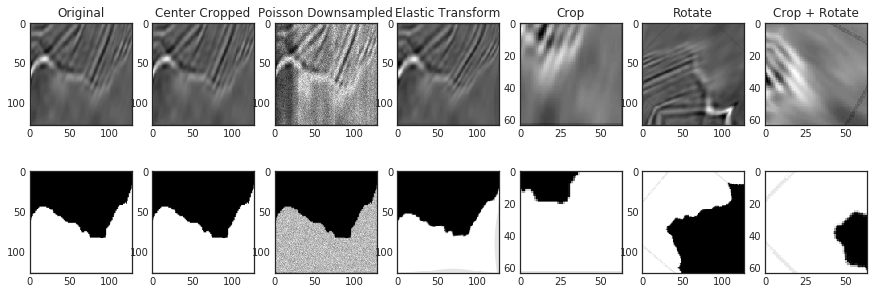

In [52]:
from torchvision.transforms import Lambda

input_channel = 1
target_channel = 1

# define a transform pipeline
transform = EnhancedCompose([
       # Merge() #,
        CenterCropNumpy(size=int(img_size_target/2)),
        RandomRotate(),
       # Split([0, input_channel], [input_channel, input_channel+target_channel]),
        #[CenterCropNumpy(size=(256, 256)), CenterCropNumpy(size=(256, 256))],
        #[NormalizeNumpy(), MaxScaleNumpy(0, 1.0)],
        # for non-pytorch usage, remove to_tensor conversion
        #[Lambda(to_tensor), Lambda(to_tensor)]
])

c_w =128
c_h = 128
import random
# read input data for test
ix = random.randint(0, x_train.shape[0])

img = x_train[ix]
img = img.squeeze()

# Multiple image
img2 = x_train[ix+1].squeeze()
imgs = []
imgs.append(img)
imgs.append(img2)

y_img = y_train[ix].squeeze()


fig, axs = plt.subplots(2, 7, figsize=(15,5))
axs[0][0].set_title('Original')
axs[0][0].imshow(img, cmap='gray')
axs[1][0].imshow(y_img, cmap='gray')

# center crop
img_c = center_crop(img, (c_w, c_h))
y_c = center_crop(y_img, (c_w, c_h))

axs[0][1].set_title('Center Cropped')
axs[0][1].imshow(img_c, cmap='gray')
axs[1][1].imshow(y_c, cmap='gray')

# poisson downsampling
img_ds = poisson_downsampling(img, c_w)
y_ds = poisson_downsampling(y_img, c_w)

axs[0][2].set_title('Poisson Downsampled')
axs[0][2].imshow(img_ds, cmap='gray')
axs[1][2].imshow(y_ds, cmap='gray')

# elastic transform
print(img.shape)
img_et = elastic_transform(img)
img_exp = np.expand_dims(img_et, 2)
y_et = elastic_transform(y_img)

axs[0][3].set_title('Elastic Transform')
axs[0][3].imshow(img_et, cmap='gray')
axs[1][3].imshow(y_et, cmap='gray')


cCrop = CenterCropNumpy(size=128) #random.randint(64, 256))
rRotate = RandomRotate()

img_c = cCrop(img) #transform(img)
y_c = cCrop(y_img) #transform(y_img)

axs[0][4].set_title('Crop')
axs[0][4].imshow(img_c, cmap='gray')
axs[1][4].imshow(y_c, cmap='gray')


img_r = rRotate(img)
y_r = rRotate(y_img)

axs[0][5].set_title('Rotate')
axs[0][5].imshow(img_r, cmap='gray')
axs[1][5].imshow(y_r, cmap='gray')

img_cr = rRotate(cCrop(img))
y_cr = rRotate(cCrop(y_img))

axs[0][6].set_title('Crop + Rotate')
axs[0][6].imshow(img_cr, cmap='gray')
axs[1][6].imshow(y_cr, cmap='gray')


In [53]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.25, stratify=train_df.coverage_class, random_state=1337)


In [ ]:
#For small dataset
#sn = 150
#ids_train = ids_train[0:sn]
#ids_valid = ids_valid[0:sn]
#x_train = x_train[0:sn]
#y_train = y_train[0:sn]
#x_valid = x_valid[0:sn]
#y_valid = y_valid[0:sn]
#cov_train = cov_train[0:sn]
#cov_test = cov_test[0:sn]
#depth_train = depth_train[0:sn]
#depth_test = depth_test[0:sn]

#x_train_tmp = np.copy(x_train)
#y_train_tmp = np.copy(y_train)

In [ ]:
# # Data Augmentation
# trans_num = 7
# rot_num = 5

# x_train = np.copy(x_train_tmp)
# y_train = np.copy(y_train_tmp)
# print(x_train.shape)
# print(y_train.shape)

# ix = random.randint(0, x_train.shape[0])
# prevSize = 0
# fig, axs = plt.subplots(1, trans_num + rot_num - 1, figsize=(15,15))
# fig2, axs2 = plt.subplots(1, trans_num + rot_num - 1, figsize=(15,15))
# axs[0].set_title('Original')
# axs[0].imshow(np.squeeze(x_train[ix]), cmap='gray')
# axs2[0].imshow(np.squeeze(y_train[ix]), cmap='gray')

# x_train_orig = np.copy(x_train)
# y_train_orig = np.copy(y_train)

# # Elastic Transform
# print("Augmenting using Elastic Transform")
# x_train_t = np.zeros((x_train_orig.shape))

# for i in range(x_train_orig.shape[0]):
#     x = np.copy(x_train_orig[i].squeeze())
#     xe = elastic_transform(x)
#     xee = xe.reshape((img_size_target, img_size_target, 1))
#     x_train_t[i] = xee
    
# prevSize = x_train.shape[0]    
# x_train = np.concatenate((x_train, x_train_t))
# print(x_train.shape)
# axs[1].set_title('Elastic Transform')
# axs[1].imshow(np.squeeze(x_train[prevSize + ix]), cmap='gray')

# y_train_t = np.zeros((y_train_orig.shape))
# for i in range(y_train_orig.shape[0]):
#     x = np.copy(y_train_orig[i].squeeze())
#     xe = elastic_transform(x)
#     xee = xe.reshape((img_size_target, img_size_target, 1))
#     y_train_t[i] = xee

# prevSize = y_train.shape[0]    
# y_train = np.concatenate((y_train, y_train_t))
# print(y_train.shape)
# axs2[1].imshow(np.squeeze(y_train[prevSize + ix]), cmap='gray')

# # left-right flip
# print("Augmenting using Left Right flip")
# prevSize = x_train.shape[0]
# x_train = np.append(x_train, [np.fliplr(x) for x in x_train_orig], axis=0)
# y_train = np.append(y_train, [np.fliplr(x) for x in y_train_orig], axis=0)
# print(x_train.shape)
# print(y_train.shape)

# axs[2].set_title('Left Right Flip Flop')
# axs[2].imshow(np.squeeze(x_train[prevSize + ix]), cmap='gray')
# axs2[2].imshow(np.squeeze(y_train[prevSize + ix]), cmap='gray')


# # up-down flip
# print("Augmenting using Up Down flip")
# prevSize = x_train.shape[0]
# x_train = np.append(x_train, [np.flipud(x) for x in x_train_orig], axis=0)
# y_train = np.append(y_train, [np.flipud(x) for x in y_train_orig], axis=0)
# print(x_train.shape)
# print(y_train.shape)

# axs[3].set_title('Up Down Flip Flop')
# axs[3].imshow(np.squeeze(x_train[prevSize + ix]), cmap='gray')
# axs2[3].imshow(np.squeeze(y_train[prevSize + ix]), cmap='gray')

# for r in range(rot_num) :
#     # random crop, random rotate
#     print(str(r) + ". Augmenting using Random Cropping and then random rotating.")
#     print(img_size_target)
#     transform = EnhancedCompose([
#             RandomRotate()
#     ])

#     cCrop = CenterCropNumpy(size=random.randint(64,256)) # Cropping diminishes the size
#     rRotate = RandomRotate()

#     x_train_t = np.zeros((x_train_orig.shape))
#     for i in range(x_train_orig.shape[0]):
#         try:
#             x = np.copy(x_train_orig[i])
#             xn = rRotate(x.squeeze())
#             xnn = xn.reshape((x.shape[0], x.shape[1], x.shape[2]))
#             x_train_t[i] = xnn
#         except:
#             continue
#         i + 1

#     prevSize = x_train.shape[0]
#     x_train = np.concatenate((x_train, x_train_t))
#     print(x_train.shape)

#     axs[4 + r].set_title('Rotation' + str(r))
#     axs[4 + r].imshow(np.squeeze(x_train[prevSize + ix]), cmap='gray')

#     y_train_t = np.zeros((y_train_orig.shape))
#     for i in range(y_train_orig.shape[0]):
#         try:
#             x = np.copy(y_train_orig[i])
#             xn = rRotate(x.squeeze())
#             xnn = xn.reshape((x.shape[0], x.shape[1], x.shape[2]))
#             y_train_t[i] = xnn
#         except:
#             continue
#         i + 1
    
#     prevSize = y_train.shape[0]
#     y_train = np.concatenate((y_train, y_train_t))
#     print(y_train.shape)      
#     axs2[4 + r].imshow(np.squeeze(y_train[prevSize + ix]), cmap='gray')

# im_id = 4 + r + 1

# print("Augmenting using Poisson Downsampling")
# x_train_t = np.zeros((x_train_orig.shape))

# for i in range(x_train_orig.shape[0]):
#     x = np.copy(x_train_orig[i].squeeze())
#     xe = poisson_downsampling(x, img_size_ori)
#     xee = xe.reshape((img_size_target, img_size_target, 1))
#     x_train_t[i] = xee
    
# prevSize = x_train.shape[0]    
# x_train = np.concatenate((x_train, x_train_t))
# print(x_train.shape)
# axs[im_id].set_title('Poisson Downsampling')
# axs[im_id].imshow(np.squeeze(x_train[prevSize + ix]), cmap='gray')

# y_train_t = np.zeros((y_train_orig.shape))
# for i in range(y_train_orig.shape[0]):
#     x = np.copy(y_train_orig[i].squeeze())
#     xe = poisson_downsampling(x, img_size_ori)
#     xee = xe.reshape((img_size_target, img_size_target, 1))
#     y_train_t[i] = xee

# prevSize = y_train.shape[0]    
# y_train = np.concatenate((y_train, y_train_t))
# print(y_train.shape)
# axs2[im_id].imshow(np.squeeze(y_train[prevSize + ix]), cmap='gray')

# im_id = im_id + 1

# print("Augmenting using Gaussian Noise")
# x_train_t = np.zeros((x_train_orig.shape))

# for i in range(x_train_orig.shape[0]):
#     x = np.copy(x_train_orig[i].squeeze())
#     gn = AddGaussianNoise(mean = x.mean(), sigma = x.std())
#     xe = gn(x)
#     xee = xe.reshape((img_size_target, img_size_target, 1))
#     x_train_t[i] = xee
    
# prevSize = x_train.shape[0]    
# x_train = np.concatenate((x_train, x_train_t))
# print(x_train.shape)
# axs[im_id].set_title('Gaussian Noise')
# axs[im_id].imshow(np.squeeze(x_train[prevSize + ix]), cmap='gray')

# y_train_t = np.zeros((y_train_orig.shape))
# for i in range(y_train_orig.shape[0]):
#     x = np.copy(y_train_orig[i].squeeze())
#     gn = AddGaussianNoise(mean = x.mean(), sigma = x.std())
#     xe = gn(x)
#     xee = xe.reshape((img_size_target, img_size_target, 1))
#     y_train_t[i] = xee

# prevSize = y_train.shape[0]    
# y_train = np.concatenate((y_train, y_train_t))
# print(y_train.shape)
# axs2[im_id].imshow(np.squeeze(y_train[prevSize + ix]), cmap='gray')

# im_id = im_id + 1

#if ip == None:
#    plt.show()
#else:
#    plt.savefig(open('../images/augmented_data.svg', 'wb'), dpi = 150)

In [54]:
# Check whether salt only train df or not (< 4000)
len(train_df)

4000

# Training

In [390]:
model_file_ini = "./keras-augment-20-coverage-class-salt-only-train-image-12Aug2018"
model_file_name = model_file_ini + ".model"
submission_file_name = model_file_ini + "-submission.csv"

In [56]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_file_name, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3000 samples, validate on 1000 samples
Epoch 1/200
3000/3000 [==============================] - 247s 82ms/step - loss: 0.5783 - acc: 0.7469 - val_loss: 0.5368 - val_acc: 0.7477

Epoch 00001: val_loss improved from inf to 0.53681, saving model to ./keras-augment-20-coverage-class-salt-only-train-image-12Aug2018.model
Epoch 2/200
3000/3000 [==============================] - 221s 74ms/step - loss: 0.5103 - acc: 0.7484 - val_loss: 0.4887 - val_acc: 0.7477

Epoch 00002: val_loss improved from 0.53681 to 0.48872, saving model to ./keras-augment-20-coverage-class-salt-only-train-image-12Aug2018.model
Epoch 3/200
3000/3000 [==============================] - 223s 74ms/step - loss: 0.4465 - acc: 0.7802 - val_loss: 0.4057 - val_acc: 0.8427

Epoch 00003: val_loss improved from 0.48872 to 0.40568, saving model to ./keras-augment-20-coverage-class-salt-only-train-image-12Aug2018.model
Epoch 4/200
3000/3000 [==============================] - 220s 73ms/step - loss: 0.3984 - acc: 0.8351 - val_

Epoch 34/200
3000/3000 [==============================] - 221s 74ms/step - loss: 0.1518 - acc: 0.9319 - val_loss: 0.1902 - val_acc: 0.9186

Epoch 00034: val_loss did not improve from 0.18287
Epoch 35/200
3000/3000 [==============================] - 214s 71ms/step - loss: 0.1509 - acc: 0.9322 - val_loss: 0.1908 - val_acc: 0.9198

Epoch 00035: val_loss did not improve from 0.18287
Epoch 36/200
3000/3000 [==============================] - 204s 68ms/step - loss: 0.1484 - acc: 0.9328 - val_loss: 0.1927 - val_acc: 0.9183

Epoch 00036: val_loss did not improve from 0.18287
Epoch 37/200
3000/3000 [==============================] - 185s 62ms/step - loss: 0.1468 - acc: 0.9332 - val_loss: 0.1866 - val_acc: 0.9217

Epoch 00037: val_loss did not improve from 0.18287
Epoch 38/200
3000/3000 [==============================] - 186s 62ms/step - loss: 0.1460 - acc: 0.9339 - val_loss: 0.1931 - val_acc: 0.9162

Epoch 00038: val_loss did not improve from 0.18287

Epoch 00038: ReduceLROnPlateau reducing lear

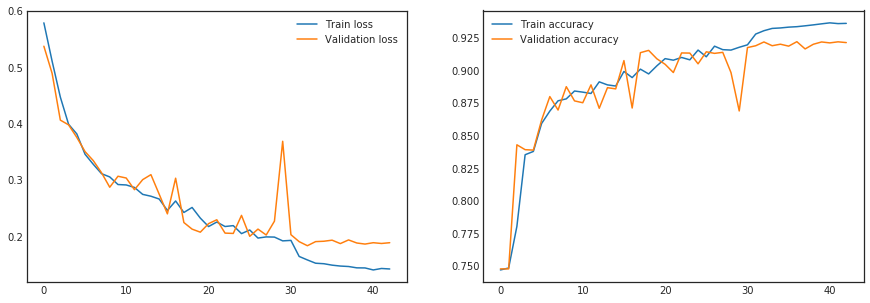

In [68]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/val_train_loss_acc_curve.svg', 'wb'), dpi=150)

In [391]:
import os
#dataset2_path = 'u-net-dropout-augmentation-stratification/'
#model_path = "../input/" + dataset2_path 

#model_dir = '../working/'

model_dir = ''

model_file = model_dir + model_file_name
if os.path.isfile(model_file):
    model = load_model(model_file)
else:
    print('Model file does not exist.')
#preds_train = model.predict(x_train[]).reshape(-1, img_size_target, img_size_target)

In [224]:
def load_model_from_weights(weight_file_name, network):
    class args_for_test:
        def __init__(self):
            pass
        
    args = args_for_test()
    args.model = weight_file_name 
    args.models_dir = 'nn_models'
    args.network = network 

    from models.model_factory import make_model
    import os
    from os import path, mkdir, listdir
    import numpy as np

    import timeit

    from keras import backend as K

    K.clear_session()

    t0 = timeit.default_timer()

    weights = os.path.join(args.models_dir, args.model)
    print("Building model {} from weights {} ".format(args.network, weights))
    model = make_model(args.network, (None, None, 3))
    model.load_weights(weights)

    elapsed = timeit.default_timer() - t0
    print('Time: {:.3f} min'.format(elapsed / 60))

    return(model)

In [249]:
# loading a model from the weights
import os

cwd = os.getcwd()
os.chdir('/home/azehady/python/salt_image_challenge/dsb2018_topcoders/selim')

img_chan = 3
model = load_model_from_weights(weight_file_name = 'best_resnet152_2_fold0.h5', network = 'resnet152_2')

print('Model loaded.')
model.summary()
os.chdir(cwd)


Building model resnet152_2 from weights nn_models/best_resnet152_2_fold0.h5 
Time: 0.373 min
Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [250]:
import os

def create_train_valid_data_for_three_channels():
    os.chdir('/home/azehady/python/salt_image_challenge/tgs/code/')

    dataset_path = "" #"tgs-salt-identification-challenge/"
    train_df = pd.read_csv("../input/"+ dataset_path + "train.csv", index_col="id", usecols=[0])
    depths_df = pd.read_csv("../input/" + dataset_path + "depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]

    train_df["images"] = [np.array(load_img("../input/" + dataset_path + "train/images/{}.png".format(idx))) / 255 for idx in tqdm_notebook(train_df.index)]
    train_df["masks"] = [np.array(load_img("../input/" + dataset_path + "train/masks/{}.png".format(idx))) / 255 for idx in tqdm_notebook(train_df.index)]
    df_pix_sum = train_df.masks.map(np.sum)
    train_df["coverage"] = df_pix_sum / (3 * pow(img_size_ori, 2))

    def cov_to_class(val):    
        for i in range(0, 21):
            if val * 20 <= i :
                return i

    train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


    # train, valid split of the data
    ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
        train_df.index.values,
        np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
        np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
        train_df.coverage.values,
        train_df.z.values,
        test_size=0.25, stratify=train_df.coverage_class, random_state=1337)

In [399]:
if img_chan == 1:
    print('Now testing the model on validation data.')
    preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
    preds_valid = np.array([downsample(x) for x in preds_valid])
    y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])
elif img_chan == 3:
    print('Creating dataset for 3 channels for loaded model.')
    create_train_valid_data_for_three_channels()
    print('Now testing the model on validation data.')
    preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
    preds_valid = np.array([downsample(x) for x in preds_valid])
    y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

Now testing the model on validation data.


In [401]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

c0cbdabcc3.png


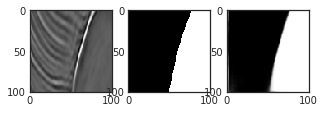

20ed65cbf8.png


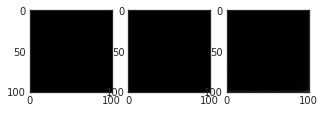

3de0c773e1.png


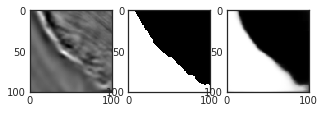

0f9977b1dd.png


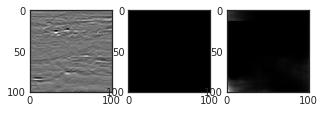

dc534f1e28.png


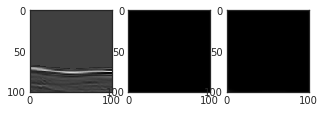

c920246511.png


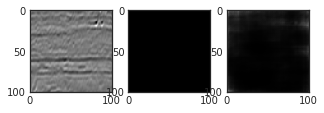

1abf3d7f60.png


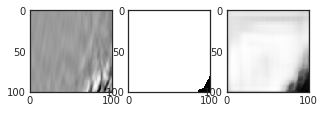

f0ec542987.png


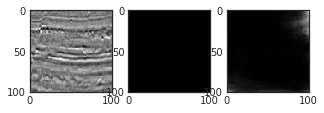

f0d15c63c5.png


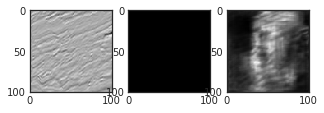

f0efea3879.png


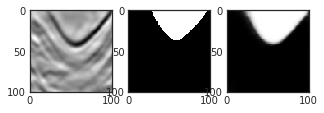

c356f76804.png


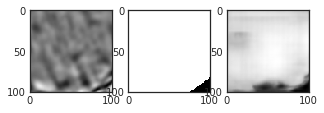

1268fbf8c2.png


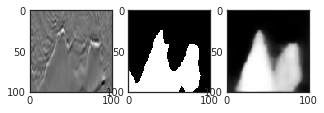

e8d6412ed8.png


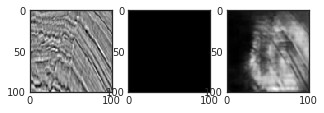

211fc910da.png


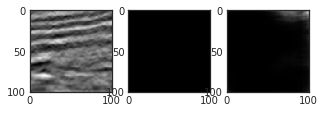

72e1a1b225.png


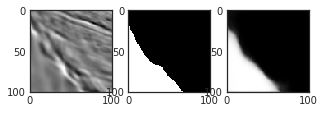

e880e84886.png


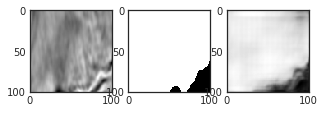

a7f7a964f5.png


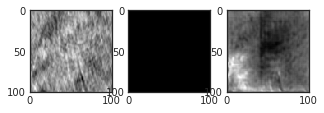

b51c130238.png


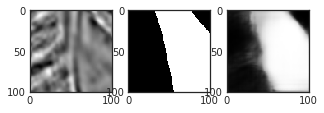

ad2113ea1c.png


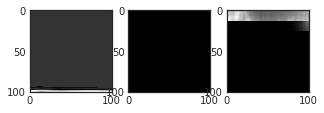

f409d55fee.png


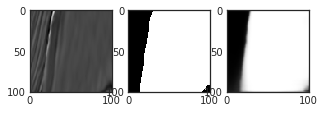

87986259f0.png


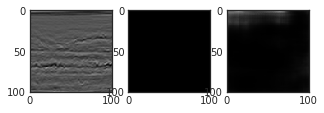

296a04bc06.png


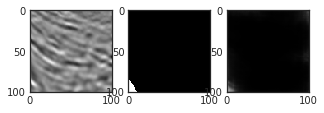

df8c73e52b.png


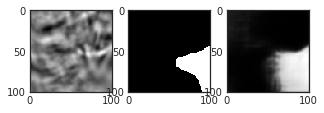

32f4fd66ae.png


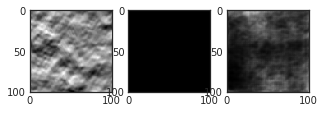

f9a3d103d7.png


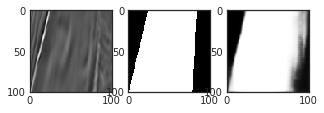

196cffdb4b.png


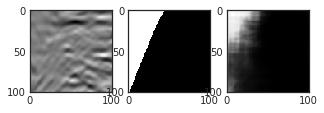

fa01eb7fdf.png


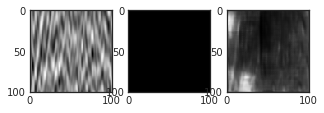

4329ab8cf6.png


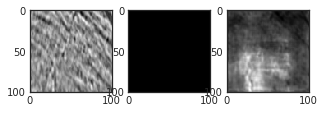

6dc7a51dd9.png


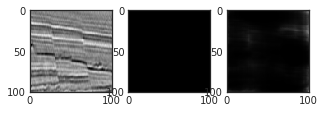

7114209cf0.png


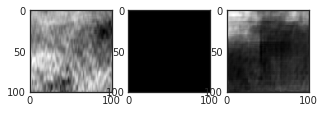

71a7c521ef.png


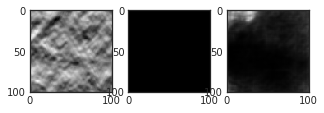

495e5d8dc0.png


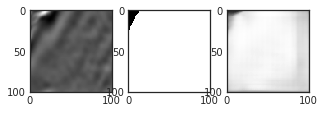

6cf6889e33.png


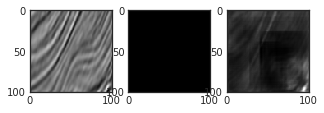

de091953f9.png


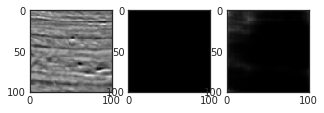

c3589905df.png


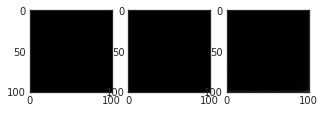

63e32c0cfb.png


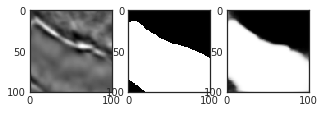

66cf41c563.png


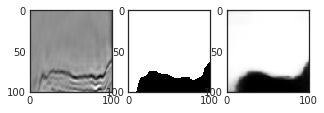

f34ae8f3d4.png


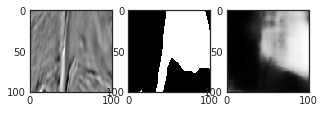

937ea43a65.png


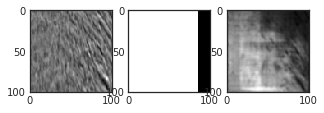

0bed5f2ace.png


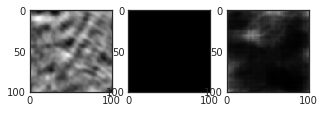

911efbb175.png


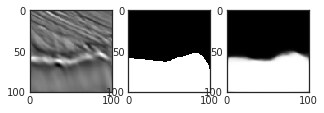

d289692ab8.png


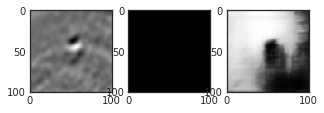

2d7a83381c.png


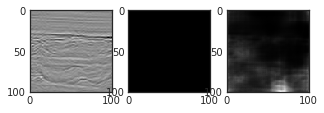

a21ae8cb6b.png


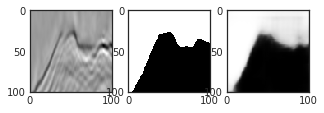

6d593a19d1.png


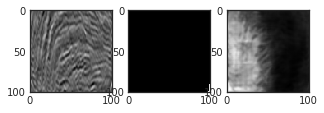

1ebc029ba0.png


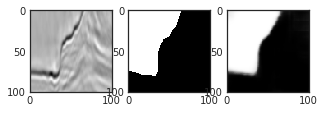

55e9012561.png


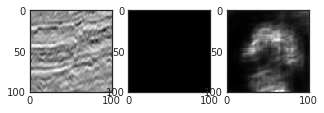

9e9f3940a9.png


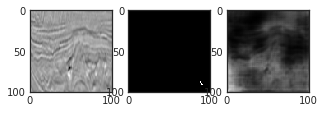

74d7a9df8b.png


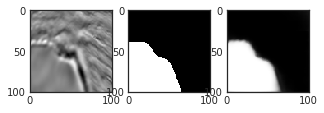

668b41c03e.png


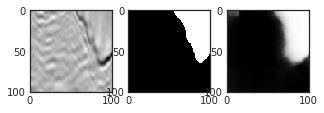

59944f0f92.png


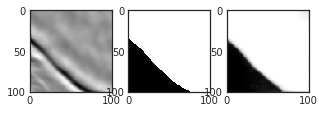

b6bbd06618.png


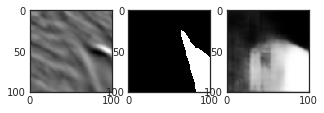

25845ace3d.png


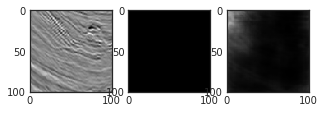

5ad4b1d1ff.png


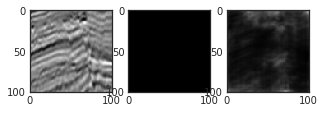

a33fe0952a.png


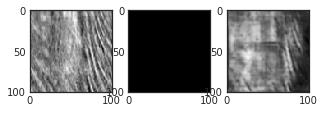

37aa9fc79a.png


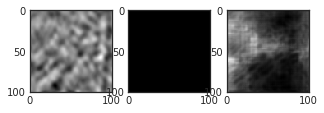

1d93cf8169.png


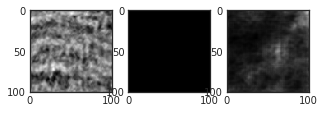

a05ae39815.png


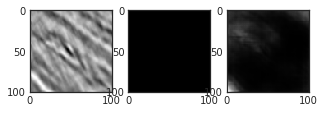

2f917b1124.png


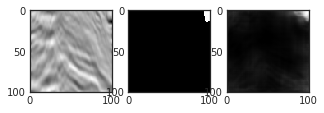

c7ab9848b9.png


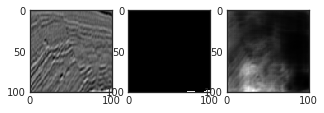

In [423]:
ids = random.randint(60, 1000)
grid_width = 15
grid_height = int(max_images / grid_width)
for i, idx in enumerate(ids_valid[0:60]): #[ids - 60 : ids]): # [0:60]): #
    print('{}.png'.format(idx))
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    
    fig, ax = plt.subplots(1, 3, figsize=(5, 5))
    ax[0].imshow(img, cmap="gray")
    ax[1].imshow(mask, cmap="gray")
    ax[2].imshow(pred, cmap="gray")
    plt.show()



if ip != None:
    plt.show()
else:
    plt.savefig(open('../images/train_valid_img_pred_test_img_' + str(i) + '.svg', 'wb'), dpi=150)
        


# Scoring
Score the model and do a threshold optimization by the best IoU.

In [80]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [73]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

In [81]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

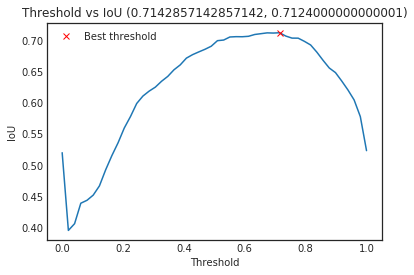

In [82]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

if ip!= None:
    plt.show()
else:
    plt.savefig(open('../images/threshold_vs_iou.svg', 'wb'), dpi=150)

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

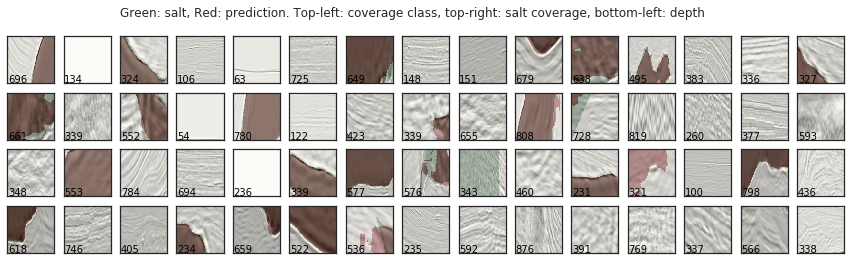

In [86]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    #ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    #ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    #ax.text(1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

if ip != None:
    plt.show()
else:
    plt.savefig(open('threshold_sanity_check.svg', 'wb'), dpi=150)

# Submission
Load, predict and submit the test image predictions.

In [87]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [88]:
x_test = np.array([upsample(np.array(load_img("../input/" + dataset_path + "test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))

In [ ]:
preds_test = model.predict(x_test)

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file_name)

In [ ]:
tL = len(x_test)
idx = random.randint(0, tL)

x = x_test[idx]
cv.imshow('img', x)